In [1]:
from scipy import *
from matplotlib.pyplot import *
from scipy.linalg import *
from numpy.linalg import *
import scipy.sparse as sparse
from scipy.sparse.linalg import splu
from timeit import default_timer as timer
import FNC

In [2]:
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
rcParams["figure.figsize"] = [7,4]
rcParams["lines.linewidth"] = 2
rcParams["lines.markersize"] = 4
rcParams['animation.html'] = "jshtml"  # or try "html5"

# Example 2.1.1

We create two vectors for data about the population of China. The first has the years of census data, the other has the numbers of millions of people.

In [3]:
year = arange(1980,2020,10)
pop = [984.736, 1148.364, 1263.638, 1330.141]

It's convenient to measure time in years since 1980. 

In [4]:
t = year - 1980
y = pop

Now we have four data points $(t_1,y_1),\dots,(t_4,y_4)$, so $n=4$ and we seek an interpolating cubic polynomial. We construct the associated Vandermonde matrix: 

In [5]:
V = vander(t)
print(V)

[[    0     0     0     1]
 [ 1000   100    10     1]
 [ 8000   400    20     1]
 [27000   900    30     1]]


To solve for the vector of polynomial coefficients, we use `solve` (from `scipy.linalg`):

In [6]:
c = solve(V,y)
print(c)

[-6.95000e-05 -2.39685e-01  1.87666e+01  9.84736e+02]


The algorithms used by the backslash operator are the main topic of this chapter. For now, observe that the coefficients of the cubic polynomial vary over several orders of magnitude, which is typical in this context. By our definitions, these coefficients are given in descending order of power in $t$.

We can use the resulting polynomial to estimate the population of China in 2005:

In [7]:
p = poly1d(c)              # construct a polynomial
p(2005-1980)               # apply the 1980 time shift

1303.0119375

The official figure is 1297.8, so our result is not bad.

We can visualize the interpolation process. First, we plot the data as points. Then we add a plot of the interpolant, taking care to shift the $t$ variable back to actual years.

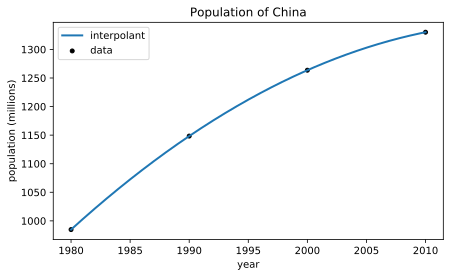

In [8]:
scatter(year,y,color="k",label="data")
tt = linspace(0,30,300)    # 300 times from 1980 to 2010
plot(1980+tt,p(tt),label="interpolant")
xlabel("year");
ylabel("population (millions)");
title("Population of China")
legend();

Let's redo it, this time continuing the curve outside of the original date range.

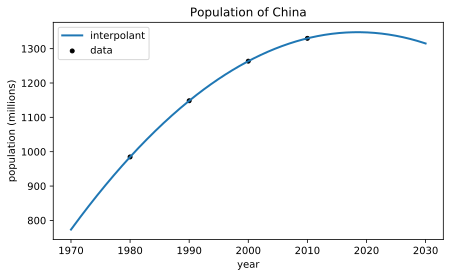

In [9]:
scatter(year,y,color="k",label="data")
tt = linspace(-10,50,300)    # 300 times from 1980 to 2010
plot(1980+tt,p(tt),label="interpolant")
xlabel("year");
ylabel("population (millions)");
title("Population of China")
legend();

While the interpolation is plausible, the extrapolation to the future is highly questionable! As a rule, extrapolation more than a short distance beyond the original interval is not reliable.

# Example 2.2.1

While Python (specifically NumPy) does have distinct representations for matrices and 2D arrays, use of the explicit matrix class is officially discouraged. We follow this advice here and use arrays to represent matrices and vectors.

A vector is created using square brackets and commas to enclose and separate its entries.

In [10]:
x = array([3, 3, 0, 1, 0 ])
x.shape

(5,)

To construct a matrix, you nest the brackets to create a "vector of vectors". The inner vectors are the rows.

In [11]:
A = array([ [1,2,3,4,5],
            [50,40,30,20,10], 
            [pi,sqrt(2),exp(1),(1+sqrt(5))/2,log(3)] 
          ])

print(A)
A.shape

[[ 1.          2.          3.          4.          5.        ]
 [50.         40.         30.         20.         10.        ]
 [ 3.14159265  1.41421356  2.71828183  1.61803399  1.09861229]]


(3, 5)

In the text we default to all vectors being equivalent to matrices with a single column. That isn't quite true in Python, because even an $n\times1$ array has two dimensions, unlike a vector.

In [12]:
array([[3],[1],[2]]).shape

(3, 1)

You can also concatenate arrays with compatible dimensions, not just numbers, using `hstack` and `vstack`.

In [13]:
print( hstack([A,A]) )

[[ 1.          2.          3.          4.          5.          1.
   2.          3.          4.          5.        ]
 [50.         40.         30.         20.         10.         50.
  40.         30.         20.         10.        ]
 [ 3.14159265  1.41421356  2.71828183  1.61803399  1.09861229  3.14159265
   1.41421356  2.71828183  1.61803399  1.09861229]]


In [14]:
print( vstack([A,A]) )

[[ 1.          2.          3.          4.          5.        ]
 [50.         40.         30.         20.         10.        ]
 [ 3.14159265  1.41421356  2.71828183  1.61803399  1.09861229]
 [ 1.          2.          3.          4.          5.        ]
 [50.         40.         30.         20.         10.        ]
 [ 3.14159265  1.41421356  2.71828183  1.61803399  1.09861229]]


Transposing a matrix is done by appending `.T` to it. For matrices with complex values, we often want instead the hermitian, which is `.conj().T`. They are the same for a real matrix.

In [15]:
A.T

array([[ 1.        , 50.        ,  3.14159265],
       [ 2.        , 40.        ,  1.41421356],
       [ 3.        , 30.        ,  2.71828183],
       [ 4.        , 20.        ,  1.61803399],
       [ 5.        , 10.        ,  1.09861229]])

In [16]:
x.conj().T

array([3, 3, 0, 1, 0])

There are many convenient shorthand ways of building vectors and matrices other than entering all of their entries directly or in a loop. To get a vector with evenly spaced entries between two endpoints, you have two options.

In [17]:
print(arange(1,7,2))      # from 1 to 7 (not inclusive), step by 2        

[1 3 5]


In [18]:
print(linspace(-1,1,5))   # from -1 to 1 (inclusive), with 5 total values

[-1.  -0.5  0.   0.5  1. ]


The practical difference between these is whether you want to specify the step size in `arange` or the number of points in `linspace`.

Accessing an element is done by giving one (for a vector) or two index values in square brackets. **In Python, indexing always starts with zero, not 1.**

In [19]:
A = array([ [1,2,3,4,5],[50,40,30,20,10], linspace(-5,5,5) ])
x = array([3, 2, 0, 1, -1 ])
print("A:",A)
print("x:",x)

A: [[ 1.   2.   3.   4.   5. ]
 [50.  40.  30.  20.  10. ]
 [-5.  -2.5  0.   2.5  5. ]]
x: [ 3  2  0  1 -1]


In [20]:
print("row 2, col 3 of A:",A[1,2])
print("first element of x:",x[0])

row 2, col 3 of A: 30.0
first element of x: 3


The indices can be ranges, in which case a **slice** or block of the matrix is accessed. You build these using a colon in the form `start:stop`. However, the last value of this range is `stop-1`, not `stop`.

In [21]:
print(A[1:3,0:2])    # rows 2 and 3, cols 1 and 2

[[50.  40. ]
 [-5.  -2.5]]


If `start` or `stop` is omitted, the range extends to the first or last index.

In [22]:
print(x[1:])  # elements 2 through the end

[ 2  0  1 -1]


In [23]:
print(A[:2,0])  # first two rows in column 1

[ 1. 50.]


Notice in the last case above that even when the slice is in the shape of a column vector, the result is just a vector with one dimension and neither row nor column shape.

There are more variations on the colon ranges. A negative value means to count from the end rather than the beginning. And a colon by itself means to include everything from the relevant dimension.

In [24]:
print(A[:-1,:])    # all rows up to the last, all columns

[[ 1.  2.  3.  4.  5.]
 [50. 40. 30. 20. 10.]]


Finally, `start:stop:step` means to step size or stride other than one. You can mix this with the other variations.

In [25]:
print(x[::2])  # all the odd indexes

[ 3  0 -1]


In [26]:
print(A[:,::-1])  # reverse the columns

[[ 5.   4.   3.   2.   1. ]
 [10.  20.  30.  40.  50. ]
 [ 5.   2.5  0.  -2.5 -5. ]]


The matrix and vector senses of addition, subtraction, and scalar multiplication and division are all handled by the usual symbols. Two matrices of the same size (what Python calls `shape`) are operated on elementwise. 

In [27]:
A - 2*ones([3,5])  # subtract two from each element

array([[-1. ,  0. ,  1. ,  2. ,  3. ],
       [48. , 38. , 28. , 18. ,  8. ],
       [-7. , -4.5, -2. ,  0.5,  3. ]])

If one operand has a smaller number of dimensions than the other, Python tries to **broadcast** it in the "missing" dimension(s), and the operation proceeds if the resulting shapes are identical. 

In [28]:
A - 2              # subtract two from each element

array([[-1. ,  0. ,  1. ,  2. ,  3. ],
       [48. , 38. , 28. , 18. ,  8. ],
       [-7. , -4.5, -2. ,  0.5,  3. ]])

In [29]:
A - array([1,2,3,4,5])  # repeat this row for every row of A

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [49. , 38. , 27. , 16. ,  5. ],
       [-6. , -4.5, -3. , -1.5,  0. ]])

In [30]:
A - array([1,2,3])  # broadcasting this would be 3x3, so it's an error

ValueError: operands could not be broadcast together with shapes (3,5) (3,) 

In [31]:
A - array([1,2,3]).reshape([3,1])    # broadcasts to each column of A

array([[ 0. ,  1. ,  2. ,  3. ,  4. ],
       [48. , 38. , 28. , 18. ,  8. ],
       [-8. , -5.5, -3. , -0.5,  2. ]])

Matrix–matrix and matrix–vector products are computed using `@` or `dot`.

In [32]:
B = diag([-1,0,-5])     # create a diagonal 3x3
print( B@A )       # matrix product

[[ -1.   -2.   -3.   -4.   -5. ]
 [  0.    0.    0.    0.    0. ]
 [ 25.   12.5   0.  -12.5 -25. ]]


$AB$ is undefined for these matrix sizes. 

In [33]:
print( A@B )

ValueError: shapes (3,5) and (3,3) not aligned: 5 (dim 1) != 3 (dim 0)

A square matrix raised to an integer power is the same as repeated matrix multiplication.

The multiplication operator `*` is reserved for elementwise multiplication. Both operands have to be the same size, after any potential broadcasts.

In [34]:
B*A

ValueError: operands could not be broadcast together with shapes (3,3) (3,5) 

In [35]:
(A/2)*A

array([[5.000e-01, 2.000e+00, 4.500e+00, 8.000e+00, 1.250e+01],
       [1.250e+03, 8.000e+02, 4.500e+02, 2.000e+02, 5.000e+01],
       [1.250e+01, 3.125e+00, 0.000e+00, 3.125e+00, 1.250e+01]])

To raise to a power elementwise, use a double star. This will broadcast as well.

In [36]:
B**3

array([[  -1,    0,    0],
       [   0,    0,    0],
       [   0,    0, -125]])

In [37]:
2.0**x

array([8. , 4. , 1. , 2. , 0.5])

Because elementwise and matrix multiplication are different, so are the following.

In [38]:
C = array([[1,2],[3,4]])
print(C**2)
print(C@C)

[[ 1  4]
 [ 9 16]]
[[ 7 10]
 [15 22]]


Most of the mathematical functions, such as cos, sin, log, exp and sqrt, expecting scalars as operands will be broadcast to arrays.

In [39]:
print(cos(pi*x))      

[-1.  1.  1. -1. -1.]


# Example 2.3.2

For a square matrix $A$, the command `solve(A,B)` is mathematically equivalent to $A^{-1}b$. 

In [40]:
A = array([[1,0,-1],[2,2,1],[-1,-3,0]])
b = array([1,2,3])

In [41]:
x = solve(A,b)
print(x)

[ 2.14285714 -1.71428571  1.14285714]


One way to check the answer is to compute a quantity known as the **residual**. It is (hopefully) close to machine precision, scaled by the size of the entries of the data. Notice that the matrix–vector multiplication here is performed by `dot`.

In [42]:
residual = b - A@x
print(residual)

[-4.4408921e-16 -4.4408921e-16  0.0000000e+00]


If the matrix $A$ is singular, you may get an error.

In [43]:
A = array([[0,1],[0,0]])
b = array([1,-1])
solve(A,b)

LinAlgError: Singular matrix

Detecting singularity is a lot like checking whether two floating point numbers are *exactly* equal: because of roundoff, it could be missed. We're headed toward a more robust way to fully describe the situation.

# Example 2.3.3

It's easy to get just the lower triangular part of any matrix using the `tril` command.

In [44]:
A = 1 + floor(9*rand(5,5))
L = tril(A)
print(L)

[[7. 0. 0. 0. 0.]
 [1. 5. 0. 0. 0.]
 [2. 1. 8. 0. 0.]
 [3. 5. 8. 8. 0.]
 [4. 5. 7. 1. 6.]]


We'll set up and solve a linear system with this matrix.

In [45]:
b = ones(5)
x = FNC.forwardsub(L,b)
print(x)

[ 0.14285714  0.17142857  0.06785714 -0.10357143 -0.13333333]


It's not clear what the error in this answer is. However, we can always check the residual.

In [46]:
b - L@x

array([0., 0., 0., 0., 0.])

Next we'll engineer a problem to which we know the exact answer. 

In [47]:
alpha = 0.3;
beta = 2.2;
U = diag(ones(5)) + diag([-1,-1,-1,-1],k=1)
U[0,3:5] = [ alpha-beta, beta ]
print(U)

[[ 1.  -1.   0.  -1.9  2.2]
 [ 0.   1.  -1.   0.   0. ]
 [ 0.   0.   1.  -1.   0. ]
 [ 0.   0.   0.   1.  -1. ]
 [ 0.   0.   0.   0.   1. ]]


In [48]:
x_exact = ones(5)
b = array([alpha,0,0,0,1])

x = FNC.backsub(U,b)
print("error:",x - x_exact)

error: [2.22044605e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


Everything seems OK here. But another example, with a different value for $\beta$, is more troubling.

In [49]:
alpha = 0.3;
beta = 1e12;
U = diag(ones(5)) + diag([-1,-1,-1,-1],k=1)
U[0,[3,4]] = [ alpha-beta, beta ]
b = array([alpha,0,0,0,1])

x = FNC.backsub(U,b)
print("error:",x - x_exact)

error: [-4.8828125e-05  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00]


It's not so good to get four digits of accuracy after starting with sixteen! But the source of the error is not hard to track down. Solving for $x_1$ performs $(\alpha-\beta)+\beta$ in the first row. Since $|\alpha|$ is so much smaller than $|\beta|$, this a recipe for losing digits to subtractive cancellation.

# Example 2.4.1

We create a 4-by-4 linear system with the matrix

In [50]:
A = array([
     [2,    0,    4,    3], 
     [-4,    5,   -7,  -10], 
     [1,   15,    2,   -4.5],
     [-2,    0,    2,  -13]
        ])

and with the right-hand side

In [51]:
b = array([ 4, 9, 29, 40 ])

We define an augmented matrix by tacking $b$ on the end as a new column.

In [52]:
S = hstack([A,b.reshape(4,1)])
print(S)

[[  2.    0.    4.    3.    4. ]
 [ -4.    5.   -7.  -10.    9. ]
 [  1.   15.    2.   -4.5  29. ]
 [ -2.    0.    2.  -13.   40. ]]


The goal is to introduce zeros into the lower triangle of this matrix. By using only elementary row operations, we ensure that the matrix $S$ always represents a linear system that is equivalent to the original. We proceed from left to right and top to bottom. The first step is to put a zero in the (2,1) location using a multiple of row 1:

In [53]:
mult21 = S[1,0]/S[0,0]
S[1,:] -= mult21*S[0,:]   # -= means "subtract the following from"
print(S)

[[  2.    0.    4.    3.    4. ]
 [  0.    5.    1.   -4.   17. ]
 [  1.   15.    2.   -4.5  29. ]
 [ -2.    0.    2.  -13.   40. ]]


We repeat the process for the (3,1) and (4,1) entries.

In [54]:
mult31 = S[2,0]/S[0,0];
S[2,:] -= mult31*S[0,:];
mult41 = S[3,0]/S[0,0];
S[3,:] -= mult41*S[0,:];
print(S)

[[  2.   0.   4.   3.   4.]
 [  0.   5.   1.  -4.  17.]
 [  0.  15.   0.  -6.  27.]
 [  0.   0.   6. -10.  44.]]


The first column has the zero structure we want. To avoid interfering with that, we no longer add multiples of row 1 to anything. Instead, to handle column 2, we use multiples of row 2. We'll also exploit the highly repetitive nature of the operations to write them as a loop. 

In [55]:
for i in range(2,4):
    mult = S[i,1]/S[1,1]
    S[i,:] -= mult*S[1,:]
print(S)

[[  2.   0.   4.   3.   4.]
 [  0.   5.   1.  -4.  17.]
 [  0.   0.  -3.   6. -24.]
 [  0.   0.   6. -10.  44.]]


We finish out the triangularization with a zero in the (4,3) place. It's a little silly to use a loop for just one iteration, but the point is to establish a pattern.

In [56]:
for i in range(3,4):
    mult = S[i,2]/S[2,2]
    S[i,:] -= mult*S[2,:]
print(S)

[[  2.   0.   4.   3.   4.]
 [  0.   5.   1.  -4.  17.]
 [  0.   0.  -3.   6. -24.]
 [  0.   0.   0.   2.  -4.]]


Recall that $S$ is an augmented matrix: it represents the system $Ux=z$, where

In [57]:
U = S[:,:-1]
z = S[:,-1:].flatten() # turn it into a proper vector
print("U=",U)
print("z=",z)

U= [[ 2.  0.  4.  3.]
 [ 0.  5.  1. -4.]
 [ 0.  0. -3.  6.]
 [ 0.  0.  0.  2.]]
z= [  4.  17. -24.  -4.]


The solutions to this system are identical to those of the original system, but this one can be solved by backward substitution.

In [58]:
x = FNC.backsub(U,z)
print(x)

[-3.  1.  4. -2.]


In [59]:
print(b - A@x)

[0. 0. 0. 0.]


# Example 2.4.2

We revisit the previous example using algebra to express the row operations on $A$.

In [60]:
A = array([[2, 0, 4, 3],[-4, 5, -7, -10],[1, 15, 2, -4.5],[-2, 0, 2, -13]])

We use the identity and its columns heavily.

In [61]:
I = eye(4)
print(I)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


The first step is to put a zero in the (2,1) location using a multiple of row 1:

In [62]:
mult21 = A[1,0]/A[0,0]
L21 = I - mult21*outer(I[:,1],I[:,0])
A = dot(L21,A)
print(A)

[[  2.    0.    4.    3. ]
 [  0.    5.    1.   -4. ]
 [  1.   15.    2.   -4.5]
 [ -2.    0.    2.  -13. ]]


In [63]:
print(L21)

[[1. 0. 0. 0.]
 [2. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


We repeat the process for the (3,1) and (4,1) entries. 

In [64]:
mult31 = A[2,0]/A[0,0]
L31 = I - mult31*outer(I[:,2],I[:,0])
A = dot(L31,A)

mult41 = A[3,0]/A[0,0];
L41 = I - mult41*outer(I[:,3],I[:,0])
A = dot(L41,A)

print(A)

[[  2.   0.   4.   3.]
 [  0.   5.   1.  -4.]
 [  0.  15.   0.  -6.]
 [  0.   0.   6. -10.]]


And so on, following the pattern as before. 

# Example 2.4.3

In [65]:
A = array([[2, 0, 4, 3],[-4, 5, -7, -10],[1, 15, 2, -4.5],[-2, 0, 2, -13]])

In [66]:
L,U = FNC.lufact(A)
print("L=",L)
print("U=",U)

L= [[ 1.   0.   0.   0. ]
 [-2.   1.   0.   0. ]
 [ 0.5  3.   1.   0. ]
 [-1.   0.  -2.   1. ]]
U= [[ 2.  0.  4.  3.]
 [ 0.  5.  1. -4.]
 [ 0.  0. -3.  6.]
 [ 0.  0.  0.  2.]]


It's best to compare two floating-point quantities by taking their difference.

In [67]:
LtimesU = L@U
print(LtimesU - A)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


(Usually we can expect "zero" only up to machine precision. However, all the exact numbers in this example are also floating-point numbers.)

To solve a linear system, we no longer need the matrix $A$. 

In [68]:
b = [4,9,29,40]
z = FNC.forwardsub(L,b)
x = FNC.backsub(U,z)
print(x)

[-3.  1.  4. -2.]


In [69]:
print(b - A@x)

[0. 0. 0. 0.]


# Example 2.5.3

In [70]:
n = 6
A = rand(n,n)
x = ones(n)
y = zeros(n)
for i in range(0,n):
    for j in range(0,n):
        y[i] += A[i,j]*x[j]   # 2 flops

Each of the loops implies a summation of flops. The total flop count for this algorithm is
\[ \sum_{i=1}^n \sum_{j=1}^n 2 = \sum_{i=1}^n 2n = 2n^2. \]
Since the matrix $A$ has $n^2$ elements, all of which have to be involved in the product, it seems unlikely that we could get a flop count that is smaller than $O(n^2)$.

Let's run an experiment with the built-in matrix-vector multiplication. We assume that flops dominate the computation time and thus measure elapsed time. 

In [71]:
n = 400*arange(1,11)
print("  n           t")
for i,n in enumerate(n):
    A = randn(n,n)  
    x = randn(n)
    start = timer()
    for j in range(1,20): A@x
    print(f"{n:5}   {timer() - start:10.3e}")

  n           t
  400    1.398e-03
  800    6.392e-03
 1200    5.121e-03
 1600    1.294e-02
 2000    2.894e-02
 2400    3.481e-02
 2800    5.686e-02
 3200    7.892e-02
 3600    9.090e-02
 4000    1.290e-01


The reason for doing multiple repetitions at each value of $n$ above is to avoid having times so short that the resolution of the timer is a factor.

# Example 2.5.4

Let's repeat the experiment of the previous example for more, and larger, values of $n$.

In [72]:
N = arange(400,6200,200)
t = zeros(len(N))
for i,n in enumerate(N):
    A = randn(n,n)  
    x = randn(n)
    start = timer()
    for j in range(1,20): A@x
    t[i] = timer() - start

Plotting the time as a function of $n$ on log-log scales is equivalent to plotting the logs of the variables, but is formatted more neatly. 

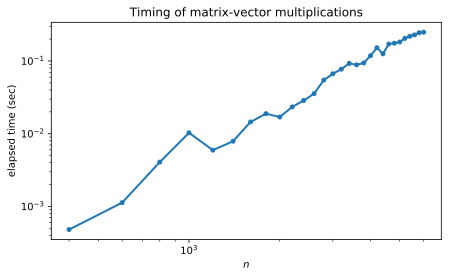

In [73]:
fig,ax = subplots()
ax.loglog(N,t,"-o",label="observed")
ylabel("elapsed time (sec)");
xlabel("$n$");
title("Timing of matrix-vector multiplications");

You can see that while the full story is complicated, the graph is trending to a straight line of positive slope. For comparison, we can plot a line that represents $O(n^2)$ growth exactly. (All such lines have slope equal to 2.)

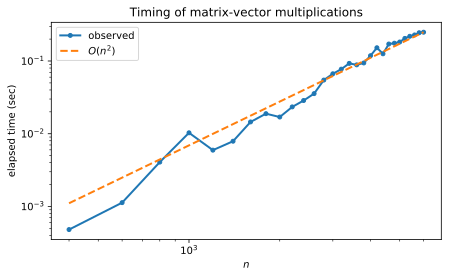

In [74]:
ax.loglog(N,(N/N[-1])**2*t[-1],"--",label="$O(n^2)$")
ax.legend();  fig

# Example 2.5.5

We'll test the conclusion of $O(n^3)$ flops experimentally, using the built-in `lu` function instead of the purely instructive `lufact`.

In [75]:
N = arange(200,2600,200)
t = zeros(len(N))
for i,n in enumerate(N):
    A = randn(n,n)  
    start = timer()
    for j in range(1,5): lu(A)
    t[i] = timer() - start

We plot the timings on a log-log graph and compare it to $O(n^3)$. The result could vary significantly from machine to machine. 

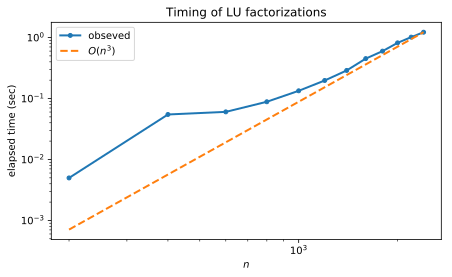

In [76]:
loglog(N,t,"-o",label="obseved")
loglog(N,(N/N[-1])**3*t[-1],"--",label="$O(n^3)$")
legend();
xlabel("$n$");
ylabel("elapsed time (sec)");
title("Timing of LU factorizations");

# Example 2.6.1

Here is the previously solved system.

In [77]:
A = array([[2, 0, 4, 3],[-4, 5, -7, -10],[1, 15, 2, -4.5],[-2, 0, 2, -13]])
b = array([ 4, 9, 29, 40 ])

It has a perfectly good solution, obtainable through LU factorization.

In [78]:
L,U = FNC.lufact(A)
x = FNC.backsub( U, FNC.forwardsub(L,b) )
print(x)

[-3.  1.  4. -2.]


If we swap the second and fourth equations, nothing essential is changed, and the built-in method still finds the solution.

In [79]:
A[[1,3],:] = A[[3,1],:]  
b[[1,3]] = b[[3,1]]
x = solve(A,b)
print(x)

[-3.  1.  4. -2.]


However, LU factorization fails.

In [80]:
L,U = FNC.lufact(A)
print(L)

[[ 1.   0.   0.   0. ]
 [-1.   1.   0.   0. ]
 [ 0.5  inf  1.   0. ]
 [-2.   inf  nan  1. ]]


/Users/driscoll/Dropbox/books/fnc-extras/python/FNC02.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  L[i,j] = U[i,j] / U[j,j]   # row multiplier
/Users/driscoll/Dropbox/books/fnc-extras/python/FNC02.py:46: RuntimeWarning: invalid value encountered in multiply
  U[i,j:] = U[i,j:] - L[i,j]*U[j,j:]
/Users/driscoll/Dropbox/books/fnc-extras/python/FNC02.py:45: RuntimeWarning: invalid value encountered in double_scalars
  L[i,j] = U[i,j] / U[j,j]   # row multiplier


# Example 2.6.2

Here is the system that "broke" LU factorization for us.

In [81]:
A = array([[2, 0, 4, 3],[-4, 5, -7, -10],[1, 15, 2, -4.5],[-2, 0, 2, -13]])
b = array([ 4, 9, 29, 40 ])

When we use the `lu` function with three outputs, we get the elements of the PLU factorization.

In [82]:
P,L,U = lu(A)
print(L)

[[ 1.          0.          0.          0.        ]
 [-0.25        1.          0.          0.        ]
 [ 0.5        -0.15384615  1.          0.        ]
 [-0.5         0.15384615  0.08333333  1.        ]]


In [83]:
print(U)

[[ -4.           5.          -7.         -10.        ]
 [  0.          16.25         0.25        -7.        ]
 [  0.           0.           5.53846154  -9.07692308]
 [  0.           0.           0.          -0.16666667]]


In [84]:
print(P)

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


However, while our notation defines $A=P^TLU$, Python is using $A=PLU$. In order to use the factors to solve the linear system, we have to use $P^T$, which equals $P^{-1}$ for a permutation matrix. 

In [85]:
x = FNC.backsub( U, FNC.forwardsub(L,dot(P.T,b)) )
print(x)

[-3.  1.  4. -2.]


If you have to solve many different linear systems for the same matrix, you can perform the computationally expensive factorization just once, and repeat only the much faster triangular solves for the different right-hand sides. 

# Example 2.7.1

The `norm` command computes vector norms.

In [86]:
x = array([2,-3,1,-1])
print( norm(x) )       # 2-norm by default

3.872983346207417


In [87]:
print( norm(x,Inf) )

3.0


In [88]:
print( norm(x,1) )

7.0


# Example 2.7.2

In [89]:
A = array([[2,0],[1,-1]])

The default matrix norm is *not* the 2-norm. Instead you must provide the 2 explicitly. 

In [90]:
print( norm(A,2) )

2.2882456112707374


You can get the 1-norm as well.

In [91]:
print( norm(A,1) )

3.0


The 1-norm is equivalent to 

In [92]:
max( sum(abs(A),0) )   # sum down the rows (dimension=0)

3

Similarly, we can get the $\infty$-norm and check our formula for it.

In [93]:
print( norm(A,Inf) )

2.0


In [94]:
max( sum(abs(A),1) )   # sum across columns (dimension=1)

2

Here we illustrate the geometric interpretation of the 2-norm. First, we will sample a lot of vectors on the unit circle in $\mathbb{R}^2$. 

In [95]:
theta = linspace(0,2*pi,601)
x = vstack([cos(theta),sin(theta)])  # 601 unit columns

We can apply `A` to every column of `x` simply by using a matrix multiplication.

In [96]:
y = A@x

We superimpose the image of the unit circle with the circle whose radius is $\|A\|_2$, and display the plots side by side.

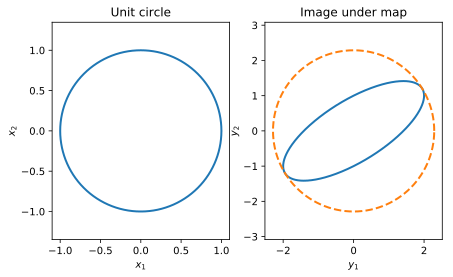

In [97]:
subplot(1,2,1)
plot(x[0,:],x[1,:])
axis("equal")
title("Unit circle")
xlabel("$x_1$")
ylabel("$x_2$");

subplot(1,2,2)
plot(y[0,:],y[1,:])
plot(norm(A,2)*x[0,:],norm(A,2)*x[1,:],"--")
axis("equal")
title("Image under map")
xlabel("$y_1$")
ylabel("$y_2$");

# Example 2.8.1

The function `cond` to computes matrix condition numbers. By default, the 2-norm is used. As an example, the family of *Hilbert matrices* is famously badly conditioned. Here is the $7\times 7$  case. 

In [98]:
A = array([[ 1/(i+j+2) for j in range(7)] for i in range(7) ])
print(A)

[[0.5        0.33333333 0.25       0.2        0.16666667 0.14285714
  0.125     ]
 [0.33333333 0.25       0.2        0.16666667 0.14285714 0.125
  0.11111111]
 [0.25       0.2        0.16666667 0.14285714 0.125      0.11111111
  0.1       ]
 [0.2        0.16666667 0.14285714 0.125      0.11111111 0.1
  0.09090909]
 [0.16666667 0.14285714 0.125      0.11111111 0.1        0.09090909
  0.08333333]
 [0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
  0.07692308]
 [0.125      0.11111111 0.1        0.09090909 0.08333333 0.07692308
  0.07142857]]


In [99]:
kappa = cond(A)
print(kappa)

1697836321.7187743


Next we engineer a linear system problem to which we know the exact answer.

In [100]:
x_exact = 1.0 + arange(7)
b = A@x_exact

Now we perturb the data randomly with a vector of norm $10^{-12}$. 

In [101]:
dA = randn(7,7)
dA = 1e-12*(dA/norm(dA,2))
db = randn(7)
db = 1e-12*(db/norm(db,2))

We solve the perturbed problem using built-in pivoted LU and see how the solution was changed.

In [102]:
x = solve(A+dA,b+db) 
dx = x - x_exact

Here is the relative error in the solution.

In [103]:
print("relative error:",norm(dx) / norm(x_exact))

relative error: 0.00012933967824127092


And here are upper bounds predicted using the condition number of the original matrix. 

In [104]:
print("b_bound:",kappa*1e-12/norm(b))
print("A_bound:",kappa*1e-12/norm(A,2))

b_bound: 0.00017690558703123912
A_bound: 0.0014498431950500583


Even if we don't make any manual perturbations to the data, machine epsilon does when we solve the linear system numerically.

In [105]:
x = solve(A,b)
print("relative error:",norm(x-x_exact) / norm(x_exact))
print("rounding bound:",kappa/2**52)

relative error: 3.6591498138119105e-08
rounding bound: 3.769953952834136e-07


Because $\kappa\approx 10^8$, it's possible to lose 8 digits of accuracy in the process of passing from $A$ and $b$ to $x$. That's independent of the algorithm; it's inevitable once the data are expressed in double precision. 

Larger Hilbert matrices are even more poorly conditioned.

In [106]:
A = array([[ 1/(i+j+2) for j in range(14)] for i in range(14) ])
kappa = cond(A)
print(kappa)

2.9943121605195904e+17


Before we compute the solution, note that $\kappa$ exceeds `1/eps`. In principle we therefore might end up with an answer that is completely wrong (i.e., a relative error greater than 100%).

In [107]:
print(kappa/2**52)

66.48708607047894


In [108]:
x_exact = 1.0 + arange(14)
b = A@x_exact  
x = solve(A,b)

We got an answer. But in fact the error does exceed 100%.

In [109]:
print("relative error:",norm(x-x_exact) / norm(x_exact))

relative error: 3.3016840182370952


# Example 2.9.1

Here is a matrix with both lower and upper bandwidth equal to one. Such a matrix is called tridiagonal.

In [110]:
A = array([ [2, -1,  0,  0,  0,  0],
            [4,  2, -1,  0,  0,  0],
            [0,  3,  0, -1,  0,  0],
            [0,  0,  2,  2, -1,  0],
            [0,  0,  0,  1,  1, -1],
            [0,  0,  0,  0,  0,  2 ]])

We can extract the elements on any diagonal using the `diag` command. The "main" or central diagonal is numbered zero, above and to the right of that is positive, and below and to the left is negative.

In [111]:
print( diag(A) )

[2 2 0 2 1 2]


In [112]:
print( diag(A,1) )

[-1 -1 -1 -1 -1]


In [113]:
print( diag(A,-1) )

[4 3 2 1 0]


We can also construct matrices by specifying a diagonal with the `diag` function.

In [114]:
A = A + diag([pi,8,6,7],2)
print(A)

[[ 2.         -1.          3.14159265  0.          0.          0.        ]
 [ 4.          2.         -1.          8.          0.          0.        ]
 [ 0.          3.          0.         -1.          6.          0.        ]
 [ 0.          0.          2.          2.         -1.          7.        ]
 [ 0.          0.          0.          1.          1.         -1.        ]
 [ 0.          0.          0.          0.          0.          2.        ]]


In [115]:
L,U = FNC.lufact(A)
print(L)

[[1.         0.         0.         0.         0.         0.        ]
 [2.         1.         0.         0.         0.         0.        ]
 [0.         0.75       1.         0.         0.         0.        ]
 [0.         0.         0.36614016 1.         0.         0.        ]
 [0.         0.         0.         0.21915497 1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


In [116]:
print(U)

[[ 2.         -1.          3.14159265  0.          0.          0.        ]
 [ 0.          4.         -7.28318531  8.          0.          0.        ]
 [ 0.          0.          5.46238898 -7.          6.          0.        ]
 [ 0.          0.          0.          4.56298115 -3.19684099  7.        ]
 [ 0.          0.          0.          0.          1.70060359 -2.53408479]
 [ 0.          0.          0.          0.          0.          2.        ]]


Observe above that the lower and upper bandwidths of $A$ are preserved in the $L$ and $U$ results.

# Example 2.9.2

We'll use a large banded matrix to observe the speedup possible in LU factorization. If we use an ordinary "dense" matrix, though, then there's no way to exploit a banded structure such as tridiagonality.

In [117]:
n = 8000
main = 1 + arange(n)
plusone = linspace(n-1,1,n-1)
minusone = ones(n-1)
A = diag(main) + diag(plusone,1) + diag(minusone,1)

In [118]:
start = timer()
lu(A)
print("time:",timer()-start)

time: 6.78849454401643


If instead we construct a proper "sparse" matrix, though, the speedup can be dramatic.

In [119]:
A = sparse.diags([main,plusone,minusone],[0,1,-1],format="csc")
start = timer()
splu(A)
print("time:",timer()-start)

time: 0.017436220980016515


# Example 2.9.3

We begin with a symmetric $A$. 

In [120]:
A = array([
    [2,     4,     4,     2],
    [4,     5,     8,    -5],
    [4,     8,     6,     2],
    [2,    -5,     2,   -26]
])

Carrying out our usual elimination in the first column leads us to 

In [121]:
L1 = eye(4)
L1[1:,0] = [-2,-2,-1]
A1 = L1@A
print(A1)

[[  2.   4.   4.   2.]
 [  0.  -3.   0.  -9.]
 [  0.   0.  -2.  -2.]
 [  0.  -9.  -2. -28.]]


But now let's note that if we transpose this result, we have the same first column as before! So we could apply  again and then transpose back.

In [122]:
A2 = (L1@A1.T).T
print(A2)

[[  2.   0.   0.   0.]
 [  0.  -3.   0.  -9.]
 [  0.   0.  -2.  -2.]
 [  0.  -9.  -2. -28.]]


Using transpose identities, this is just

In [123]:
A2 = A1@L1.T
print(A2)

[[  2.   0.   0.   0.]
 [  0.  -3.   0.  -9.]
 [  0.   0.  -2.  -2.]
 [  0.  -9.  -2. -28.]]


Now you can see how we proceed down and to the right, eliminating in a column and then symmetrically in the corresponding row.

In [124]:
L2 = eye(4)
L2[2:,1] = [0,-3]
A3 = L2@A2@L2.T
print(A3)

[[ 2.  0.  0.  0.]
 [ 0. -3.  0.  0.]
 [ 0.  0. -2. -2.]
 [ 0.  0. -2. -1.]]


Finally, we arrive at a diagonal matrix.

In [125]:
L3 = eye(4)
L3[3,2] = -1
D = L3@A3@L3.T
print(D)

[[ 2.  0.  0.  0.]
 [ 0. -3.  0.  0.]
 [ 0.  0. -2.  0.]
 [ 0.  0.  0.  1.]]


# Example 2.9.4

A randomly chosen matrix is extremely unlikely to be symmetric. However, there is a simple way to symmetrize one.

In [126]:
A = 1.0 + floor(9*rand(4,4))
B = A + A.T
print(B)

[[10. 11. 13.  6.]
 [11.  2.  7.  2.]
 [13.  7. 10.  8.]
 [ 6.  2.  8. 10.]]


Similarly, a random symmetric matrix is unlikely to be positive definite. The Cholesky algorithm always detects a non-PD matrix by quitting with an error.

In [127]:
cholesky(B)

LinAlgError: Matrix is not positive definite

It's not hard to manufacture an SPD matrix to try out the Cholesky factorization.

In [128]:
B = A.T@A
R = cholesky(B)
print(R)

[[ 9.69535971  0.          0.          0.        ]
 [ 3.81625861  2.72693421  0.          0.        ]
 [11.13934946  4.5800011   1.39229435  0.        ]
 [ 5.46653261  3.35112517  3.41754317  2.28196846]]


In [129]:
norm(R@R.T - B)

1.879919374704706e-14